In [1]:
from torch import nn
import torch
from einops import rearrange
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.datasets import Planetoid
from matplotlib import pyplot as plt

In [2]:
def create_adjacency_matrix(edge_index, num_nodes):
    adjacency_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)

    for i in range(edge_index.size(1)):
        source = edge_index[0, i]
        target = edge_index[1, i]
        adjacency_matrix[source, target] = 1

    return adjacency_matrix


def create_degree_matrix(adjacency_matrix):
    # 各行の要素の合計を計算し、それを逆数にする
    degree_vector = torch.sum(adjacency_matrix, dim=1)
    # 逆数を計算し、ゼロ除算を防ぐためにepsを加算
    inv_degree_vector = 1.0 / (degree_vector + torch.finfo(torch.float32).eps)
    # 対角行列として設定
    degree_matrix = torch.diag(inv_degree_vector)

    return degree_matrix


def create_dad(edge_index, num_nodes):
    A = create_adjacency_matrix(edge_index, num_nodes)
    D = create_degree_matrix(A)
    return D @ A @ D

In [3]:
class GraphConv(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.5):
        super(GraphConv, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.conv = nn.Conv2d(in_features, out_features, kernel_size=1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input, adj):
        input = rearrange(input, "V C -> C 1 V")
        XW = self.conv(input)
        XW = XW.squeeze(1)
        XW = self.dropout(XW)  # ドロップアウトを適用

        DADXW = torch.einsum("CV,VW->CW", XW, adj)
        DADXW = rearrange(DADXW, "C V -> V C")
        return DADXW


In [4]:
# データセットを読み込む
dataset = Planetoid(root="./Cora", name="Cora")
print(
    f"""
    グラフ構造の数: {len(dataset)}
    クラス数: {dataset.num_classes}
    特徴量の次元数: {dataset.num_node_features}
    ノード数: {dataset[0].num_nodes}
    エッジ数: {dataset[0].num_edges}
"""
)


    グラフ構造の数: 1
    クラス数: 7
    特徴量の次元数: 1433
    ノード数: 2708
    エッジ数: 10556



/Users/satooru/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and t

In [5]:
# ノードの数
num_nodes = dataset[0].num_nodes
# 特徴量の次元数
in_channels = dataset.num_node_features
#
out_channels = dataset.num_classes
# 特徴量行列
X = dataset[0].x
# ラベル
y = dataset[0].y

# DAD行列
DAD = create_dad(dataset[0].edge_index, num_nodes)

In [6]:
# モデルの定義
model = GraphConv(in_channels, out_channels)

# データセットの作成
data = TensorDataset(X, y)
loader = DataLoader(data, batch_size=200)

# モデルの実行
new_X_tensor = model(X, DAD)
new_X = new_X_tensor.detach().numpy()


1433 7


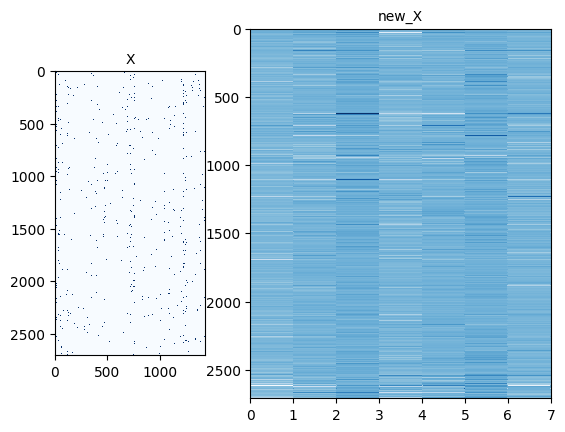

In [14]:
# 結果の図示
fig, ax = plt.subplots(1, 2, width_ratios=[4, 8])
ax[0].pcolor(X, cmap=plt.cm.Blues)
ax[0].set_aspect('equal', 'box')
ax[0].set_title('X', fontsize=10)
ax[0].invert_yaxis()

ax[1].pcolor(new_X, cmap=plt.cm.Blues)
# ax[1].set_aspect('equal', 'box')
ax[1].set_title('new_X', fontsize=10)
ax[1].invert_yaxis()